In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/pj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Preprocessing
Integrating datasets into two data frames, True and False

In [2]:
df1 = pd.read_csv('Data/archive/Fake.csv')
df1['label'] = 'Fake'
del df1['subject']
del df1['date']

In [3]:
df2 = pd.read_csv('Data/archive/True.csv')
df2['label'] = 'True'
del df2['subject']
del df2['date']

In [4]:
df3 = pd.read_csv('Data/fake_or_real_news.csv')
del df3['Unnamed: 0']
df3['label'] = df3['label'].replace(['FAKE', 'REAL'], ['Fake', 'True'])

In [5]:
df4 = pd.read_csv('Data/fake.csv')
df4['label'] = 'Fake'
df4 = df4[['title', 'text', 'label']].copy()

In [6]:
frames = [df1, df2, df3, df4]
data = pd.concat(frames)
data.sample(20)

,title,text,label
21404,EXPOSED POPULATION CONTROL CAMPAIGN: Influenti...,The same guy who donated tens of millions of d...,Fake
19600,Kenya court: opposition didn't show presidenti...,NAIROBI (Reuters) - Kenya s chief justice said...,True
9106,Factbox: Eyes on U.S. terrorism watchlists aft...,"(Reuters) - As facts emerge about Omar Mateen,...",True
16435,OBAMA STONEWALLING ON Why He Sent 13 Payments ...,Leave it to the one and only Andrew McCarthy t...,Fake
4887,Tillerson's use of email alias at Exxon 'entir...,(Reuters) - U.S. Secretary of State Rex Tiller...,True
15400,Kremlin warns of mutual damage if Ukraine cuts...,MOSCOW (Reuters) - The Kremlin said on Wednesd...,True
6280,Bette Midler Takes Hilariously Vulgar Shot At...,Superstar Bette Midler has been having a high ...,Fake
10718,"Rubio gets boost from Republican endorsements,...",WASHINGTON (Reuters) - Republican presidential...,True
11710,A Reader Is Inspired To Grassroots Activism By...,X Dear Reader! VDARE.com isn’t just a website....,Fake
4668,"Jerusalem in Photos from 1862: No mosques, no ...","Jerusalem in Photos from 1862: No mosques, no ...",Fake


### Modified data quality report
Helps determine what further cleaning needs to be done

In [7]:
# Constructing a data quality report for the data
cat_data = {'Feature': ['title', 'text', 'label'],
            'Count': data.count(),
            '% Missing': data.isnull().sum() * 100 / len(data),
            'Cardinality': data.apply(pd.Series.nunique),
            'Mode': [data.mode()['title'][0], 'null', data.mode()['label'][0]],
            'Mode Freq.': ['14', '769', '39644'],
            'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
    
            'Notes': ['', '', '']}
cat_dqr_df = pd.DataFrame(cat_data)
cat_dqr_df.reset_index(drop=True, inplace=True)
cat_dqr_df

,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,63552,1.058662,53541,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,64186,0.071615,54064,null,769,1.198081,
2,label,64232,0.000000,2,Fake,39644,61.720015,


In [8]:
data.drop_duplicates(inplace = True)

dfTrue = data[data['label'] == 'True']
dfFake = data[data['label'] == 'Fake']

dfFake.info()
dfTrue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30752 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   30122 non-null  object
 1   text    30706 non-null  object
 2   label   30752 non-null  object
dtypes: object(3)
memory usage: 961.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24351 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24351 non-null  object
 1   text    24351 non-null  object
 2   label   24351 non-null  object
dtypes: object(3)
memory usage: 761.0+ KB


In [9]:
p = 0.2  # Keep 20% of the data.
dfTrue = dfTrue.head(int(p * dfTrue.shape[0]))
dfFake = dfFake.head(int(p * dfFake.shape[0]))

### Data Cleaning
Removing stopwords, punctuation, and whitespace characters

In [10]:
def clean_string(input):
    stops = set(stopwords.words("english"))  # Set of stopwords

    input_tokenized = word_tokenize(input)   # Tokenize input
    input_without_sw = [word for word in input_tokenized if not word in stops]  # Remove stopwords
    input = (" ").join(input_without_sw)  # Combine back into sentence

    input = input.lower()
    input = re.sub('\n|\r|\t', '', input)   # Remove whitespace chars
    input = re.sub(r'[^\w\s]+', '', input)  # Remove punctuation
    
    
    return input

def preprocess(df):
    df.dropna(axis=0, inplace = True)  # Remove rows with missing values
    cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
    df['title'] = cleanfunc(df['title'])
    df['text'] = cleanfunc(df['text'])
    return df

In [11]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

                                                  title  \
0     as us budget fight looms  republicans flip fis...   
1     us military accept transgender recruits monday...   
2     senior us republican senator  let mr mueller job    
3     fbi russia probe helped australian diplomat ti...   
4     trump wants postal service charge much  amazon...   
...                                                 ...   
4900  agriculture leaders slam trump s usda budget c...   
4901  boeing  lockheed martin winners trump s 2017 s...   
4902  senators press trump details icahn s special a...   
4903  oklahoma lawmaker  found boy motel  charged pr...   
4904      treasury s mnuchin says trump want trade wars   

                                                   text label  
0     washington  reuters   the head conservative re...  True  
1     washington  reuters   transgender people allow...  True  
2     washington  reuters   the special counsel inve...  True  
3     washington  reuters   trump c

### Feature Extraction & Visualization
a) Character count in Title and Text

In [55]:
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]

def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='Type of News', legend=False,
                    ylabel='Characters', title=f'Average char count of {field} field in each type of news')  
  plt.xticks(rotation=0)
  plt.show()
  

def char_stats(dfTrue, dfFake, field):
  print(f"Character Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Distribution of title


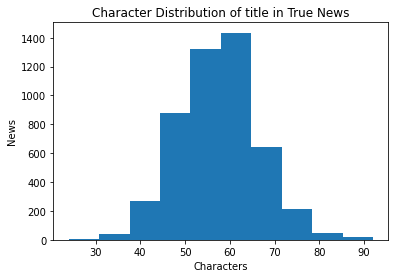

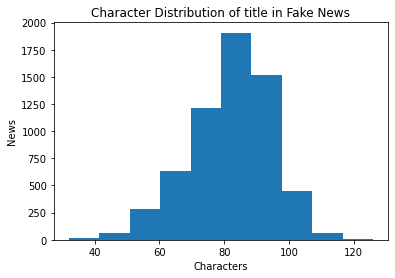

Average count of title


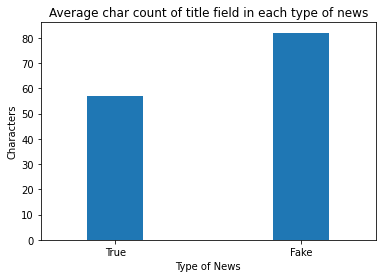

Character Distribution of text


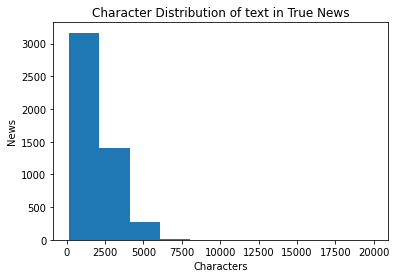

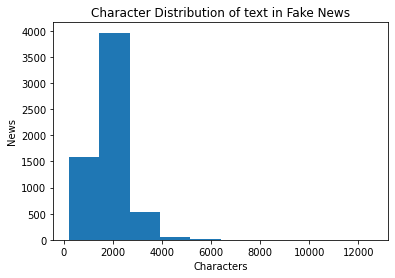

Average count of text


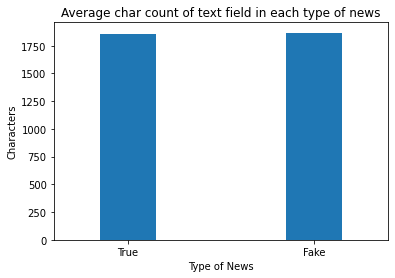

In [57]:
char_stats(dfTrue, dfFake, 'title')
char_stats(dfTrue, dfFake, 'text')